Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
import timm

In [4]:
torch.cuda.empty_cache()

In [5]:
from util import *

In [6]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [7]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                v2.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.ToImage(), 
                              v2.ToDtype(torch.float32, scale=True),
                              v2.Resize(size=235),
                              v2.CenterCrop(size=(224, 224)),
                              v2.Normalize([0.4850, 0.4560, 0.4060], [0.2290, 0.2240, 0.2250]),
                              v2.RandomApply(random_trans, 0.5)])

transform_eval = v2.Compose([v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True)])

In [8]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [9]:
# creat a dictionary that maps index to label
data_dir='../ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [10]:
button_train = CropButtonDataset('../ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=45, shuffle=True)

button_val = CropButtonDataset('../ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=True)

button_test = CropButtonDataset('../ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [11]:
loader_train

In [12]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([20, 3, 320, 320])
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1])


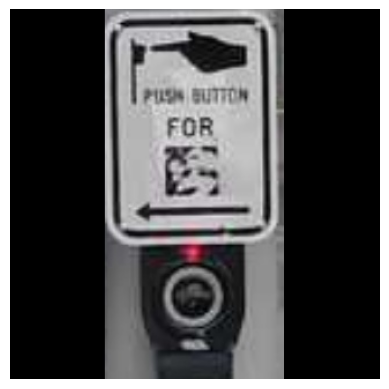

In [13]:
tensor_img = images[0]

to_pil = ToPILImage()
pil_img = to_pil(tensor_img.cpu())  

plt.imshow(pil_img)
plt.axis('off')
plt.show()

Model setup

In [18]:
class Resnet18BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = 'resnet18.a1_in1k',
        hidden_dim: int = 512,
        dropout_prob: float = 0.5,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) Load pretrained ResNet18 backbone (no classifier head)
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)

        # 2) Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, hidden_dim),  # get output dim from backbone
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # binary output
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

Check augmentation

In [19]:
# import timm
# from timm.data import resolve_data_config, create_transform

# model = timm.create_model('resnet18.a1_in1k', pretrained=True)
# config = resolve_data_config({}, model=model)
# transform = create_transform(**config)


In [20]:
# transform

test backbone

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = Resnet18BinaryClassifier().to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Logits: tensor([[-0.0403],
        [-0.1522]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


Find best hyperparameter

In [ ]:
arch = ("Resnet18BinaryClassifier", 256, 0.5)
best_model, best_params, best_training_data = hyperparameter_search(Resnet18BinaryClassifier, arch, loader_train, loader_val, device)

In [17]:
# check_accuracy_final(loader_test, best_model, True)

Train best model

In [18]:
final_model = Dinov2BinaryClassifier(hidden_dim=512, dropout_prob=0.5)

In [19]:
from torchinfo import summary
summary(final_model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                                       Output Shape              Param #
Dinov2BinaryClassifier                                       [1, 1]                    --
├─Dinov2Model: 1-1                                           [1, 384]                  --
│    └─Dinov2Embeddings: 2-1                                 [1, 485, 384]             526,848
│    │    └─Dinov2PatchEmbeddings: 3-1                       [1, 484, 384]             226,176
│    │    └─Dropout: 3-2                                     [1, 485, 384]             --
│    └─Dinov2Encoder: 2-2                                    [1, 485, 384]             --
│    │    └─ModuleList: 3-3                                  --                        21,302,784
│    └─LayerNorm: 2-3                                        [1, 485, 384]             768
├─Sequential: 1-2                                            [1, 1]                    --
│    └─Linear: 2-4                                           [1, 512]       

In [20]:
# hard code best paramm
lr = 5e-05
wd= 2e-2
beta = (0.9, 0.998)

In [ ]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr},
                {"params": final_model.classifier.parameters(), "lr": lr},
            ],
            weight_decay=wd,
            betas= beta)
data = train(final_model, optimizer, loader_train, loader_val, device, earlystop=True, epochs=140)

Iter: 1/280   |  Loss: 0.697678  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Sample preds : [45.0%, 43.7%, 42.5%, 44.5%, 42.7%, 40.9%, 44.4%, 45.3%, 42.9%, 44.1%, 43.8%, 39.3%, 44.5%, 42.0%, 44.8%, 42.3%, 44.6%, 44.3%, 44.8%]
Sample labels: [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Iter: 2/280   |  Loss: 0.877466  |  Train Acc: 0.5233  |  Val Acc: 0.4737 
Iter: 3/280   |  Loss: 0.704725  |  Train Acc: 0.4767  |  Val Acc: 0.5263 
Sample preds : [56.1%, 56.4%, 56.7%, 56.9%, 56.1%, 55.1%, 56.7%, 54.4%, 57.9%, 57.1%, 51.7%, 54.6%, 57.4%, 54.8%, 53.3%, 57.0%, 54.7%, 57.4%, 56.9%]
Sample labels: [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]
Iter: 4/280   |  Loss: 0.703505  |  Train Acc: 0.4767  |  Val Acc: 0.5263 
Iter: 5/280   |  Loss: 0.702511  |  Train Acc: 0.4884  |  Val Acc: 0.5789 
Sample preds : [44.7%, 47.3%, 47.0%, 48.1%, 48.5%, 45.7%, 48.1%, 47.6%, 46.1%, 47.8%, 47.6%, 47.5%, 45.6%

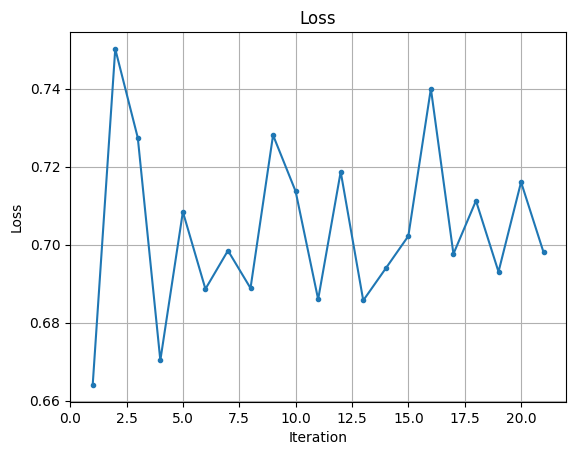

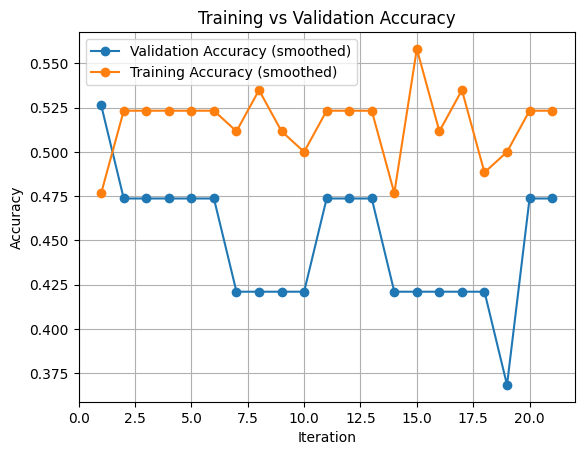

In [ ]:
plotpic(data, smooth_window=15)

In [ ]:
check_accuracy_final(loader_test, final_model, device, out=True)

Sample preds : [5.7%, 2.7%, 6.9%, 22.6%, 94.7%, 92.4%, 18.7%, 17.3%, 6.4%, 94.3%, 3.1%, 93.8%, 72.9%, 3.8%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.5714285714285714

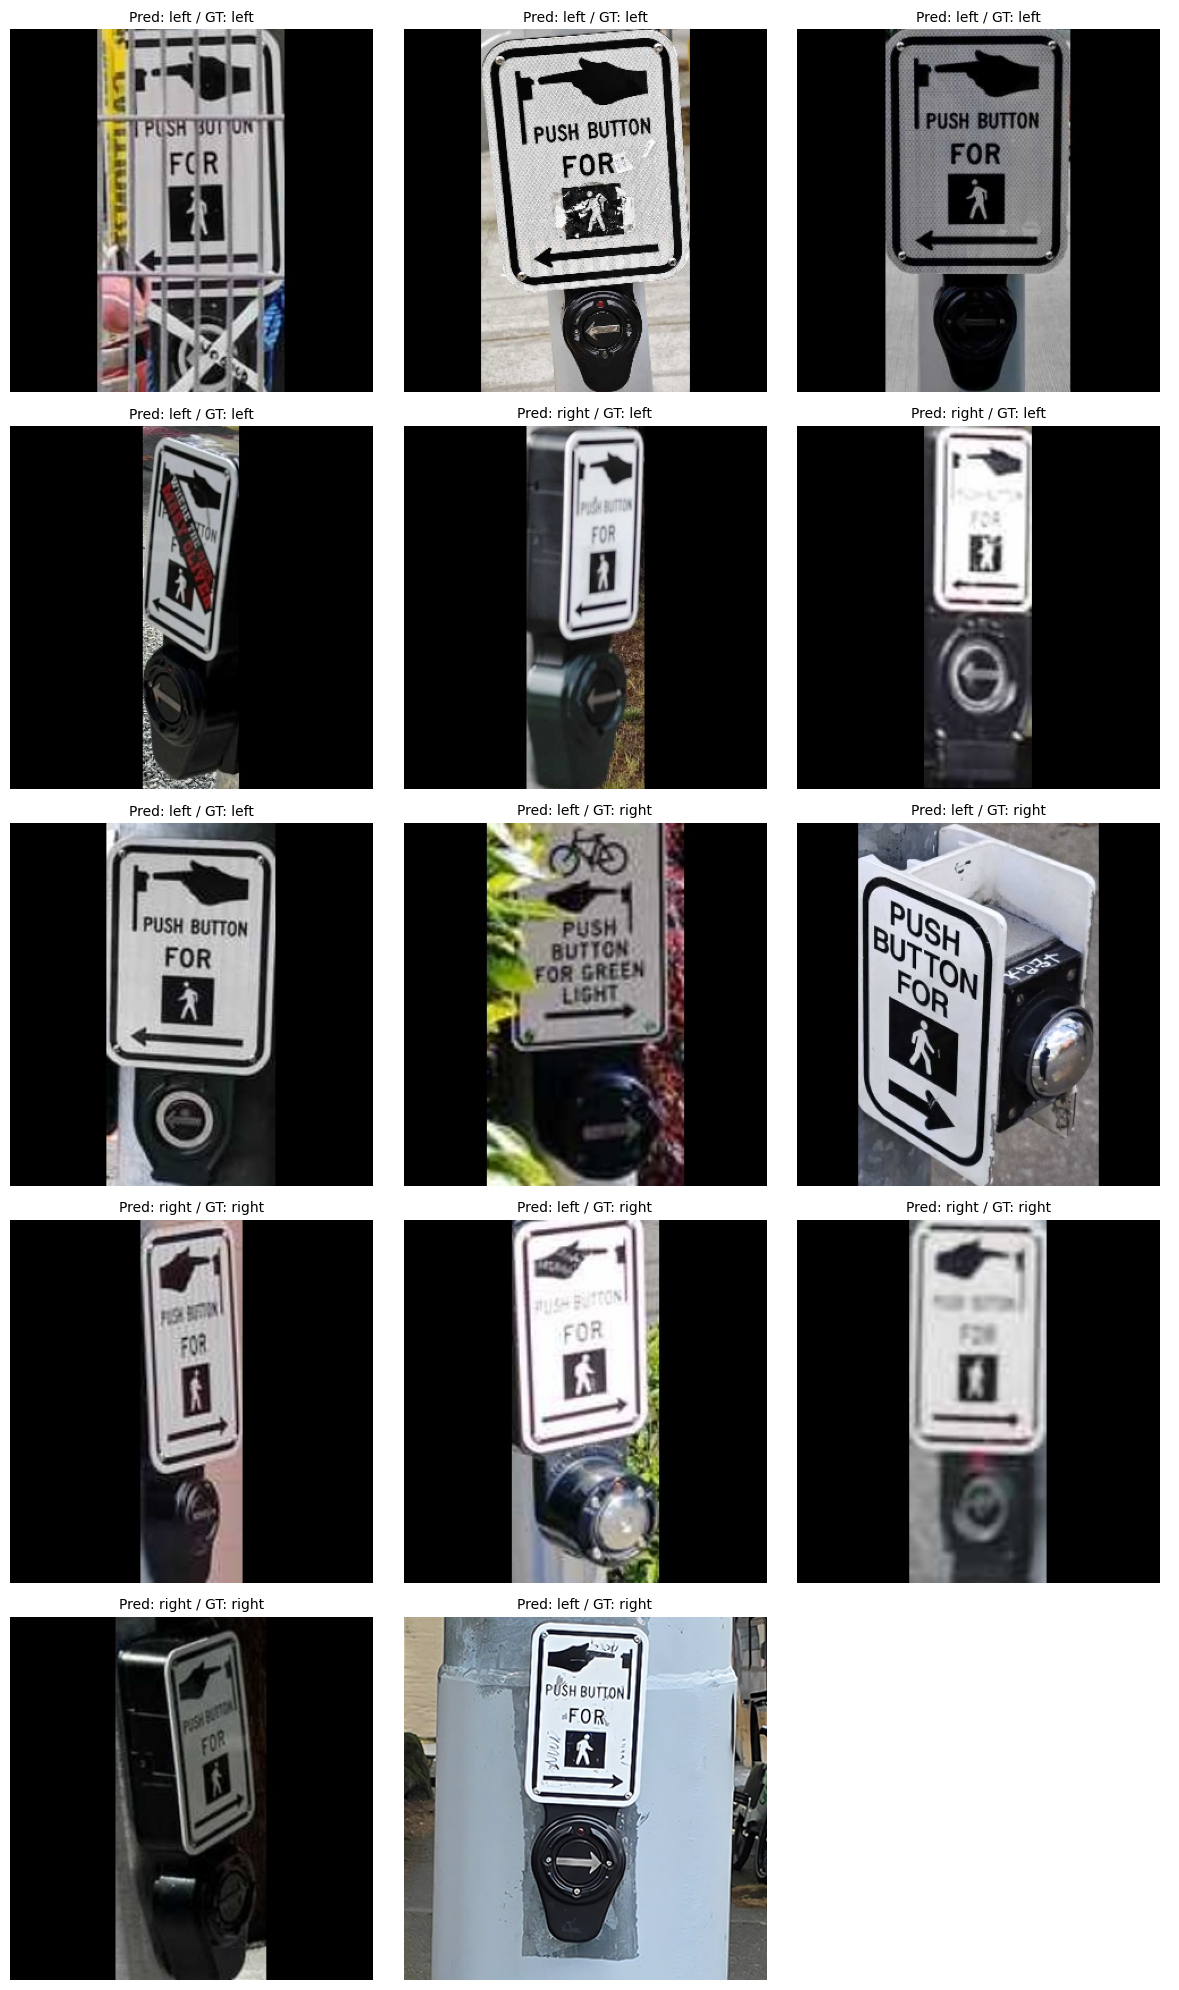

In [ ]:
show_predictions_grid(loader_test, final_model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [ ]:
torch.save(final_model.state_dict(), "dinov2_small_wo.pth")